In [1]:
import scanpy as sc
import pandas as pd
from matplotlib import pylab
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import itertools
import numpy as np
import random
import anndata as ad
from scipy.sparse import  csr_matrix, issparse
from scipy import sparse

from matplotlib.colors import TwoSlopeNorm

import scanpy.external as sce
import sys

In [2]:
import anndata

In [3]:
anndata.__version__

'0.10.8'

In [8]:
sc.settings.set_figure_params(dpi=100, facecolor='white', dpi_save=500)
pylab.rcParams['figure.figsize'] = (9, 9)
homeDir = os.getenv("HOME")
sys.path.insert(1, homeDir+"/utils/")
from PlotPCA_components import *
from PurgeAdata import *


DS="androgen_substudy"

In [9]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
anndata2ri.activate()
%load_ext rpy2.ipython
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/tmp/ipykernel_546255/1930539381.py:4: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [10]:
random.seed(1)


# Import

In [11]:
adata = sc.read_h5ad("./adatas/3.Endpoints.{}.h5ad".format(DS))
adata

AnnData object with n_obs × n_vars = 47648 × 36601
    obs: 'tags', 'cmo', 'condition', 'replicate', 'condition_clean', 'line', 'run', 'sample_id', 'groupCov', 'harmonizedRegion', 'tissue', 'PCW', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'log_pct_counts_hb', 'log_total_counts', 'study', 'hormones_substudy', 'EDCs_substudy', 'androgen_substudy', 'controls_substudy'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [12]:
adata = adata[adata.obs[DS]]
adata

View of AnnData object with n_obs × n_vars = 47648 × 36601
    obs: 'tags', 'cmo', 'condition', 'replicate', 'condition_clean', 'line', 'run', 'sample_id', 'groupCov', 'harmonizedRegion', 'tissue', 'PCW', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'log_pct_counts_hb', 'log_total_counts', 'study', 'hormones_substudy', 'EDCs_substudy', 'androgen_substudy', 'controls_substudy'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [13]:
adata.layers["counts"] = adata.X.copy()

/tmp/ipykernel_546255/1517723426.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


# Extract relevant GOs

In [14]:
from goatools.go_search import GoSearch
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.cli.ncbi_gene_results_to_python import ncbi_tsv_to_py
from goatools.base import download_ncbi_associations

gene2go = download_ncbi_associations()
objanno = Gene2GoReader("gene2go", taxids=[9606])
go2geneids_human = objanno.get_id2gos(namespace='BP', go2geneids=True)
srchhelp = GoSearch("./resources/go-basic.obo", go2items=go2geneids_human)


ncbi_tsv = '/group/testa/Users/davide.castaldi/ENDPOINTS_sc/resources/gene_result.txt'
output_py = 'genes_ncbi_9606_proteincoding.py'
ncbi_tsv_to_py(ncbi_tsv, output_py)


from goatools.associations import read_ncbi_gene2go

gene2go = read_ncbi_gene2go("./resources/gene2go", taxids=[9606])  # Taxonomy ID for Homo sapiens




from collections import defaultdict


# Specify the GO term of interest
RelevantOntologies = {"GO:0034976":"ER_stress",
"GO:0001666":"Hypoxia",
"GO:0097300":"programmed_necrotic_cell_death",
"GO:0062098":"regulation_of_programmed_necrotic_cell_death",
"GO:0097385":"programmed_necrotic_cell_death_in_response_to_starvation",
"GO:0062100":"positive_regulation_of_programmed_necrotic_cell_death",
"GO:0062099":"negative_regulation_of_programmed_necrotic_cell_death",
"GO:1902445":"regulation_of_mitochondrial_membrane_permeability_involved_in_programmed_necrotic_cell_death",
"GO:0070266":"necroptotic_process"}




go_to_genes = defaultdict(set)
RelevantGO_dict = defaultdict(set)
for gene_id, go_terms in gene2go.items():
    for go_term in go_terms:
        if go_term in list(RelevantOntologies.keys()):
           RelevantGO_dict[go_term].add(gene_id)




  EXISTS: gene2go
HMS:0:01:26.628789 362,876 annotations, 20,818 genes, 18,767 GOs, 1 taxids READ: gene2go 
12230 IDs in loaded association branch, BP
./resources/go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms; optional_attrs(comment def relationship synonym xref)
      20,614 lines READ:  /group/testa/Users/davide.castaldi/ENDPOINTS_sc/resources/gene_result.txt
      20,595 geneids WROTE: genes_ncbi_9606_proteincoding.py
DEPRECATED read_ncbi_gene2go: USE Gene2GoReader FROM goatools.anno.genetogo_reader
DEPRECATED read_ncbi_gene2go CALLED FROM: /tmp/ipykernel_546255/1653780176.py BY <module>
HMS:0:01:22.133481 362,876 annotations, 20,818 genes, 18,767 GOs, 1 taxids READ: ./resources/gene2go 
18744 IDs in loaded association branch, BP


In [15]:

from genes_ncbi_9606_proteincoding import GENEID2NT


RelevantGO_dict_Symbols = {}
for ontology in list(RelevantGO_dict.keys()):
    RelevantGO_dict_Symbols[RelevantOntologies[ontology]] = []
    genes = RelevantGO_dict[ontology]
    print("Genes associated with GO term {} ({}) in humans:".format(ontology,RelevantOntologies[ontology]))
    for gene_id in genes:
        if GENEID2NT.get(gene_id, None):
            Symbol = GENEID2NT.get(gene_id, None).Symbol
            RelevantGO_dict_Symbols[RelevantOntologies[ontology]].append(Symbol)
    if len(RelevantGO_dict_Symbols[RelevantOntologies[ontology]]) < 5:
        RelevantGO_dict_Symbols.pop(RelevantOntologies[ontology], None)
        print("{} having too few annotated genes, it will be removed".format(RelevantOntologies[ontology]))
    else:
        print(RelevantGO_dict_Symbols[RelevantOntologies[ontology]])
    print("\n")




Genes associated with GO term GO:0001666 (Hypoxia) in humans:
['SOX4', 'CYP1A1', 'EPO', 'HSP90B1', 'ABAT', 'HIF1A', 'ERCC2', 'ERCC3', 'HK2', 'PSEN2', 'TM9SF4', 'CD24', 'MB', 'PENK', 'SRF', 'CYGB', 'FUNDC1', 'ITGA2', 'HMOX2', 'ACVRL1', 'ADA', 'ACE', 'PLEKHN1', 'ALKBH5', 'F7', 'MECP2', 'PGF', 'CHRNA4', 'CHRNA7', 'CHRNB2', 'RYR1', 'RYR2', 'ITPR1', 'ITPR2', 'FZD4', 'CITED2', 'ADM', 'ADORA1', 'PTK2B', 'BMP2', 'LONP1', 'BNIP3', 'ADIPOQ', 'NF1', 'KCNA5', 'ADSL', 'SOD2', 'CXCR4', 'SOD3', 'AGER', 'KCNJ8', 'PIN1', 'KCNJ11', 'UCP2', 'UCP3', 'ARNT2', 'PKLR', 'KCNMA1', 'DIO3', 'PLAT', 'PLAU', 'ALAD', 'ALAS2', 'ADAM17', 'SCFD1', 'MMP2', 'HSD11B2', 'USF1', 'MMP14', 'TXN2', 'VEGFD', 'PLOD1', 'PLOD2', 'NOS1', 'NOS2', 'CXCL12', 'VCAM1', 'PML', 'RAD21', 'VEGFA', 'VEGFB', 'CA9', 'VEGFC', 'AGTRAP', 'DPP4', 'HSPG2', 'DDIT4', 'EGLN2', 'EGLN3', 'NPPC', 'DRD2', 'ANG', 'SLC11A2', 'ANGPT2', 'COMT', 'LIMD1', 'NOL3', 'SLC2A8', 'NGB', 'FOSL2', 'EGLN1', 'CAPN2', 'APAF1', 'NR4A2', 'CASP3', 'WDR83', 'BIRC2', 'CASP9', 

# Quick data prep

In [16]:
# Quick prep of data
sc.pp.filter_genes(adata,min_cells=1)
sc.pp.normalize_total(adata, 20000)
sc.pp.log1p(adata)
sc.pp.scale(adata)

/tmp/ipykernel_546255/3224423605.py:3: FutureWarning: The specified parameters ('target_sum',) are no longer positional. Please specify them like `target_sum=20000`
  sc.pp.normalize_total(adata, 20000)


In [17]:
# Since score genes is not consistent even setting the same seed we hash-store the result after running it for consistency 
import hashlib

for k in list(RelevantGO_dict_Symbols.keys()):
    CommonGenes = [i for i in RelevantGO_dict_Symbols[k] if i in adata.var_names]
    GOscoreHash = hashlib.sha256(pd.DataFrame(np.dot(adata[:,CommonGenes].X.T, pd.get_dummies(adata.obs["condition"])).sum(axis = 0)).to_csv(index=False).encode('utf-8')).hexdigest()
    hashFile = "./adatas/Score_{}.{}.{}.xlsx".format(k,DS,GOscoreHash)
    if os.path.isfile(hashFile):
        print(f"Precomputed score found, retrieving {hashFile}")
        Score =  pd.read_excel(hashFile, index_col=0)
    else:
        print(f"Computing score for {k}")
        Score = sc.tl.score_genes(adata, gene_list=CommonGenes, score_name="ScoreSignature_{}".format(k),random_state=1,copy=True).obs["ScoreSignature_{}".format(k)]
        Score.to_excel(hashFile)
    
    adata.obs["ScoreSignature_{}".format(k)] = Score

Computing score for Hypoxia
Computing score for ER_stress
Computing score for necroptotic_process
Computing score for programmed_necrotic_cell_death


In [18]:
adata.X = adata.layers["counts"].copy()

# We first check condition-wise across replicates to be sure we do not cut signatures(features) induced by treatments

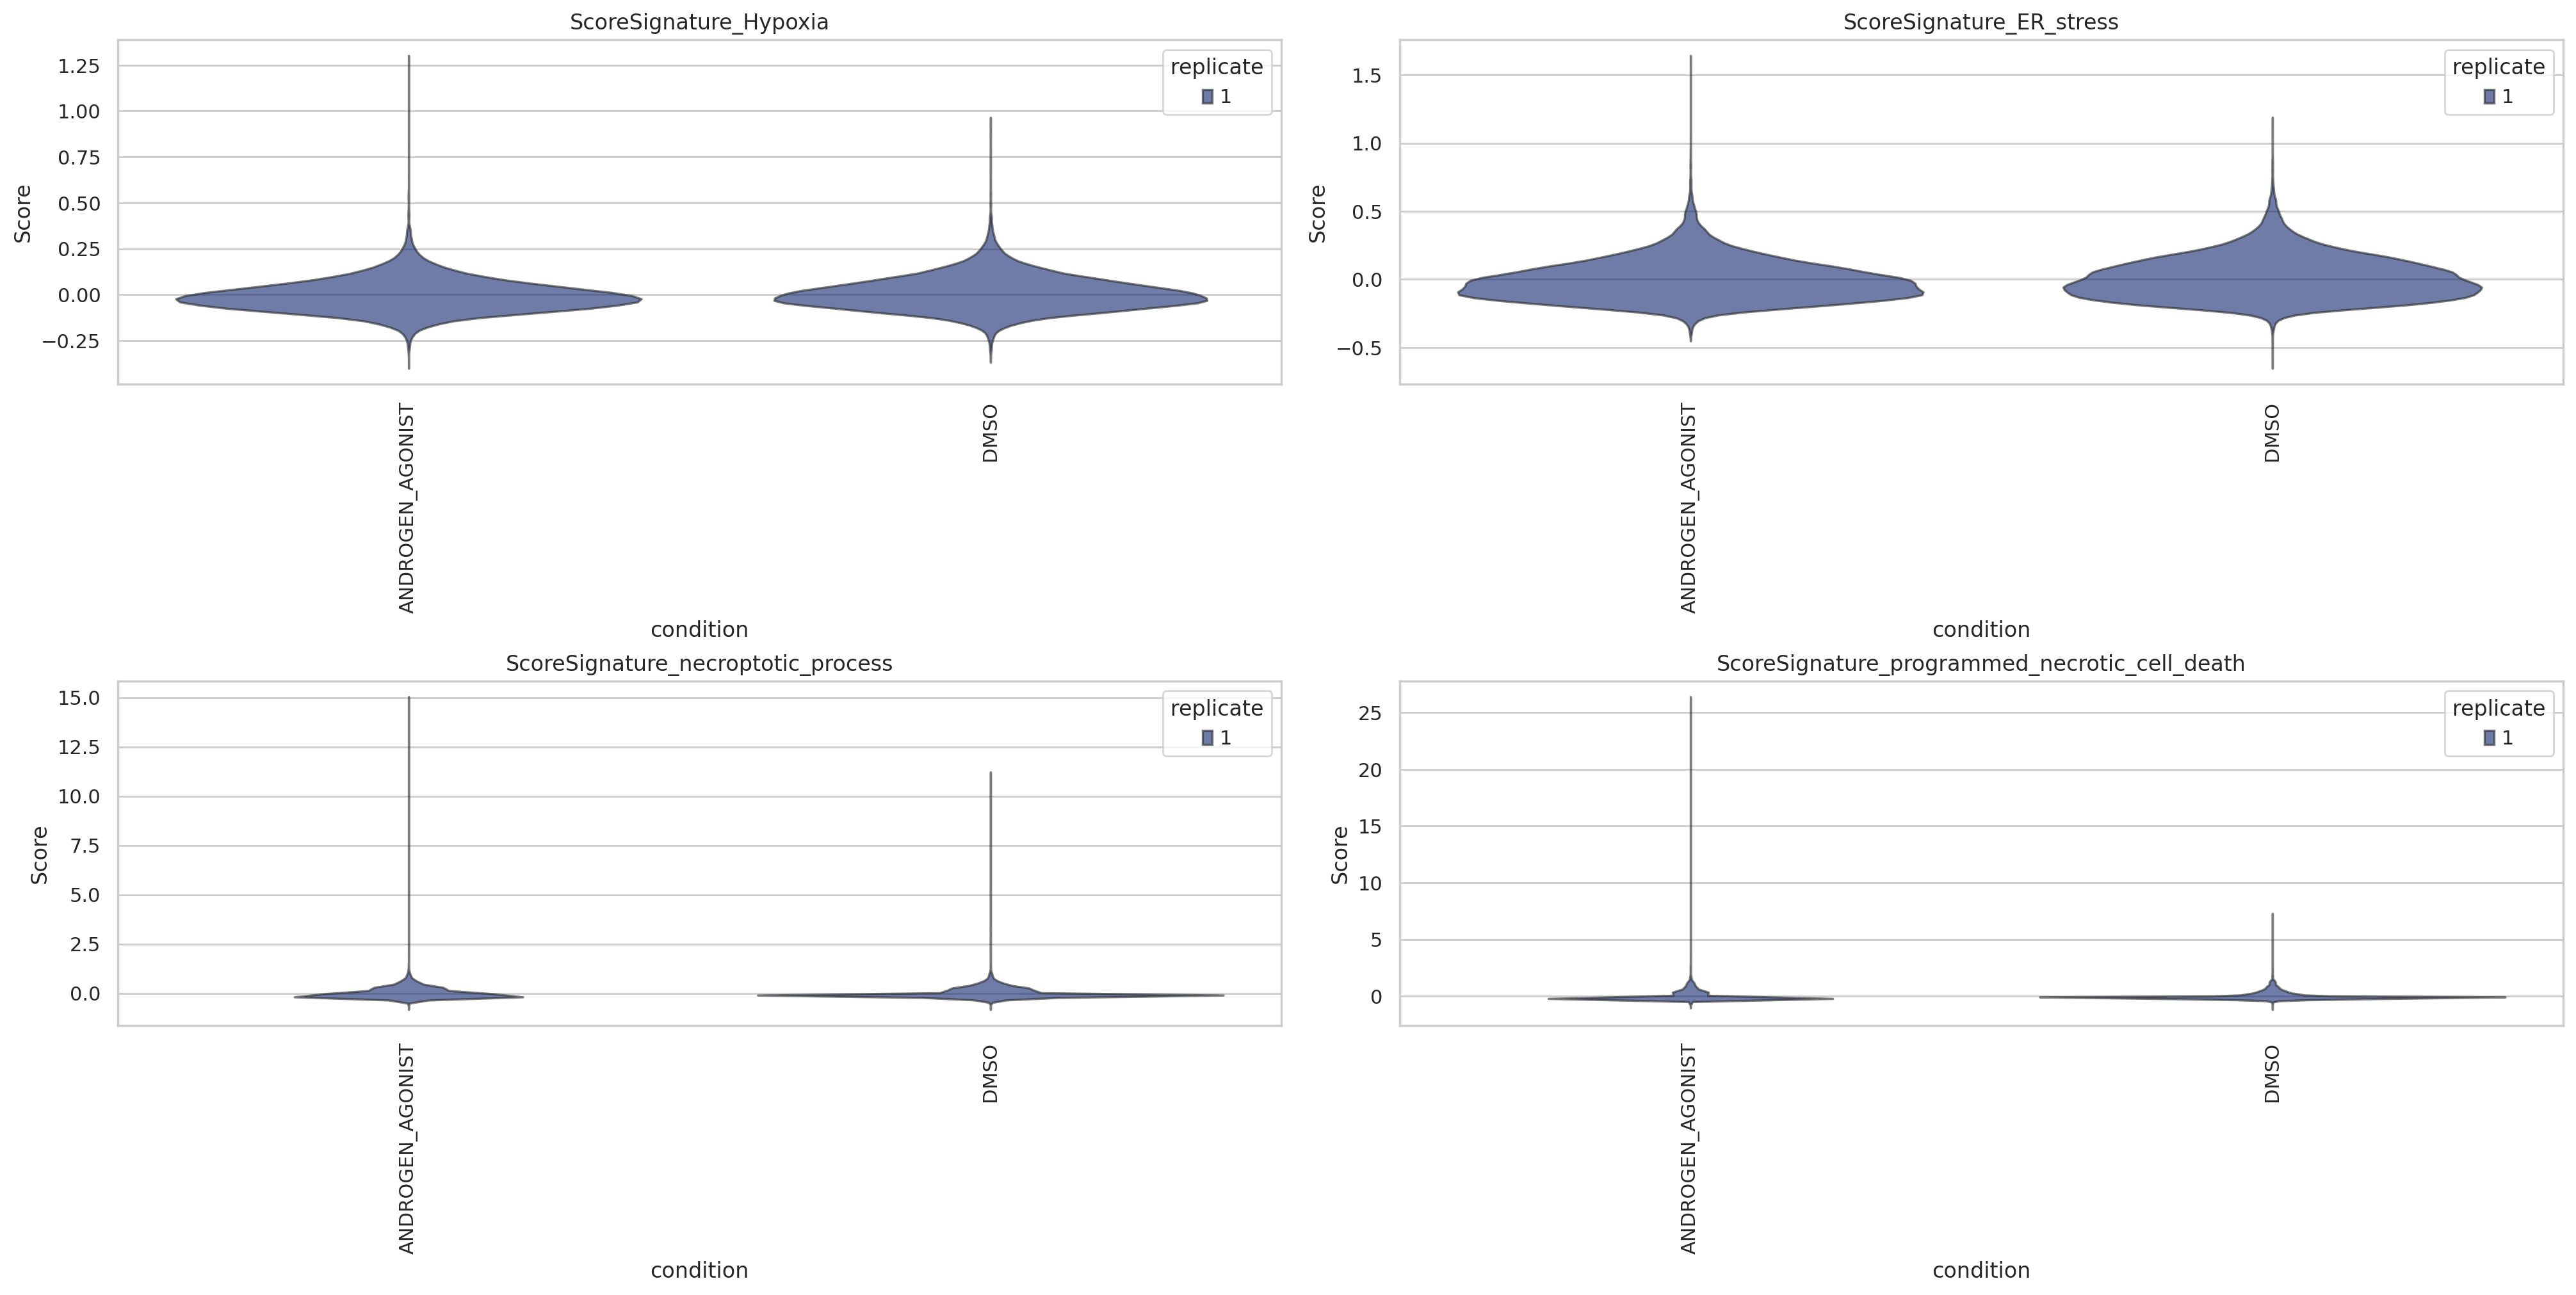

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the theme
sns.set_theme(style="whitegrid")

# Identify the signatures
signatures = [s for s in adata.obs.columns if "ScoreSignature_" in s]

# Set up subplots
n_cols = 2  # Number of columns
n_rows = len(signatures) // n_cols + (len(signatures) % n_cols > 0)  # Number of rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), constrained_layout=True)

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot each signature
for n, signature in enumerate(signatures):
    sns.violinplot(
        data=adata.obs,inner=None,
        x="condition", y=signature, hue="replicate", palette="dark", alpha=.6, ax=axes[n]
    )
    axes[n].set_title(signature)
    axes[n].set_ylabel("Score")  # Set y-axis label
    axes[n].tick_params(axis="x", rotation=90)  # Rotate x-axis tick labels

# Remove unused axes
for i in range(len(signatures), len(axes)):
    fig.delaxes(axes[i])

# Show the plot
plt.show()


## There not seem to be specific signature induction upon exposure, MAD based filter should do the job fine also in this case

## Let's go for a mild trim to improve QC evaluation

In [20]:
adata

AnnData object with n_obs × n_vars = 47648 × 33025
    obs: 'tags', 'cmo', 'condition', 'replicate', 'condition_clean', 'line', 'run', 'sample_id', 'groupCov', 'harmonizedRegion', 'tissue', 'PCW', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'log_pct_counts_hb', 'log_total_counts', 'study', 'hormones_substudy', 'EDCs_substudy', 'androgen_substudy', 'controls_substudy', 'ScoreSignature_Hypoxia', 'ScoreSignature_ER_stress', 'ScoreSignature_necroptotic_process', 'ScoreSignature_programmed_necrotic_cell_death'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropo

In [21]:
adata = adata[(adata.obs["ScoreSignature_Hypoxia"] < 0.4) & 
(adata.obs["ScoreSignature_ER_stress"] < 0.5) & 
(adata.obs["ScoreSignature_necroptotic_process"] < 5) & 
(adata.obs["ScoreSignature_programmed_necrotic_cell_death"] < 5)].copy()
adata

AnnData object with n_obs × n_vars = 47245 × 33025
    obs: 'tags', 'cmo', 'condition', 'replicate', 'condition_clean', 'line', 'run', 'sample_id', 'groupCov', 'harmonizedRegion', 'tissue', 'PCW', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'log_pct_counts_hb', 'log_total_counts', 'study', 'hormones_substudy', 'EDCs_substudy', 'androgen_substudy', 'controls_substudy', 'ScoreSignature_Hypoxia', 'ScoreSignature_ER_stress', 'ScoreSignature_necroptotic_process', 'ScoreSignature_programmed_necrotic_cell_death'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropo

In [22]:
adata = adata[(adata.obs["ScoreSignature_Hypoxia"] < 0.4) & 
(adata.obs["ScoreSignature_ER_stress"] < 0.5) & 
(adata.obs["ScoreSignature_necroptotic_process"] < 5) & 
(adata.obs["ScoreSignature_programmed_necrotic_cell_death"] < 5)].copy()
adata

AnnData object with n_obs × n_vars = 47245 × 33025
    obs: 'tags', 'cmo', 'condition', 'replicate', 'condition_clean', 'line', 'run', 'sample_id', 'groupCov', 'harmonizedRegion', 'tissue', 'PCW', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'log_pct_counts_hb', 'log_total_counts', 'study', 'hormones_substudy', 'EDCs_substudy', 'androgen_substudy', 'controls_substudy', 'ScoreSignature_Hypoxia', 'ScoreSignature_ER_stress', 'ScoreSignature_necroptotic_process', 'ScoreSignature_programmed_necrotic_cell_death'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropo

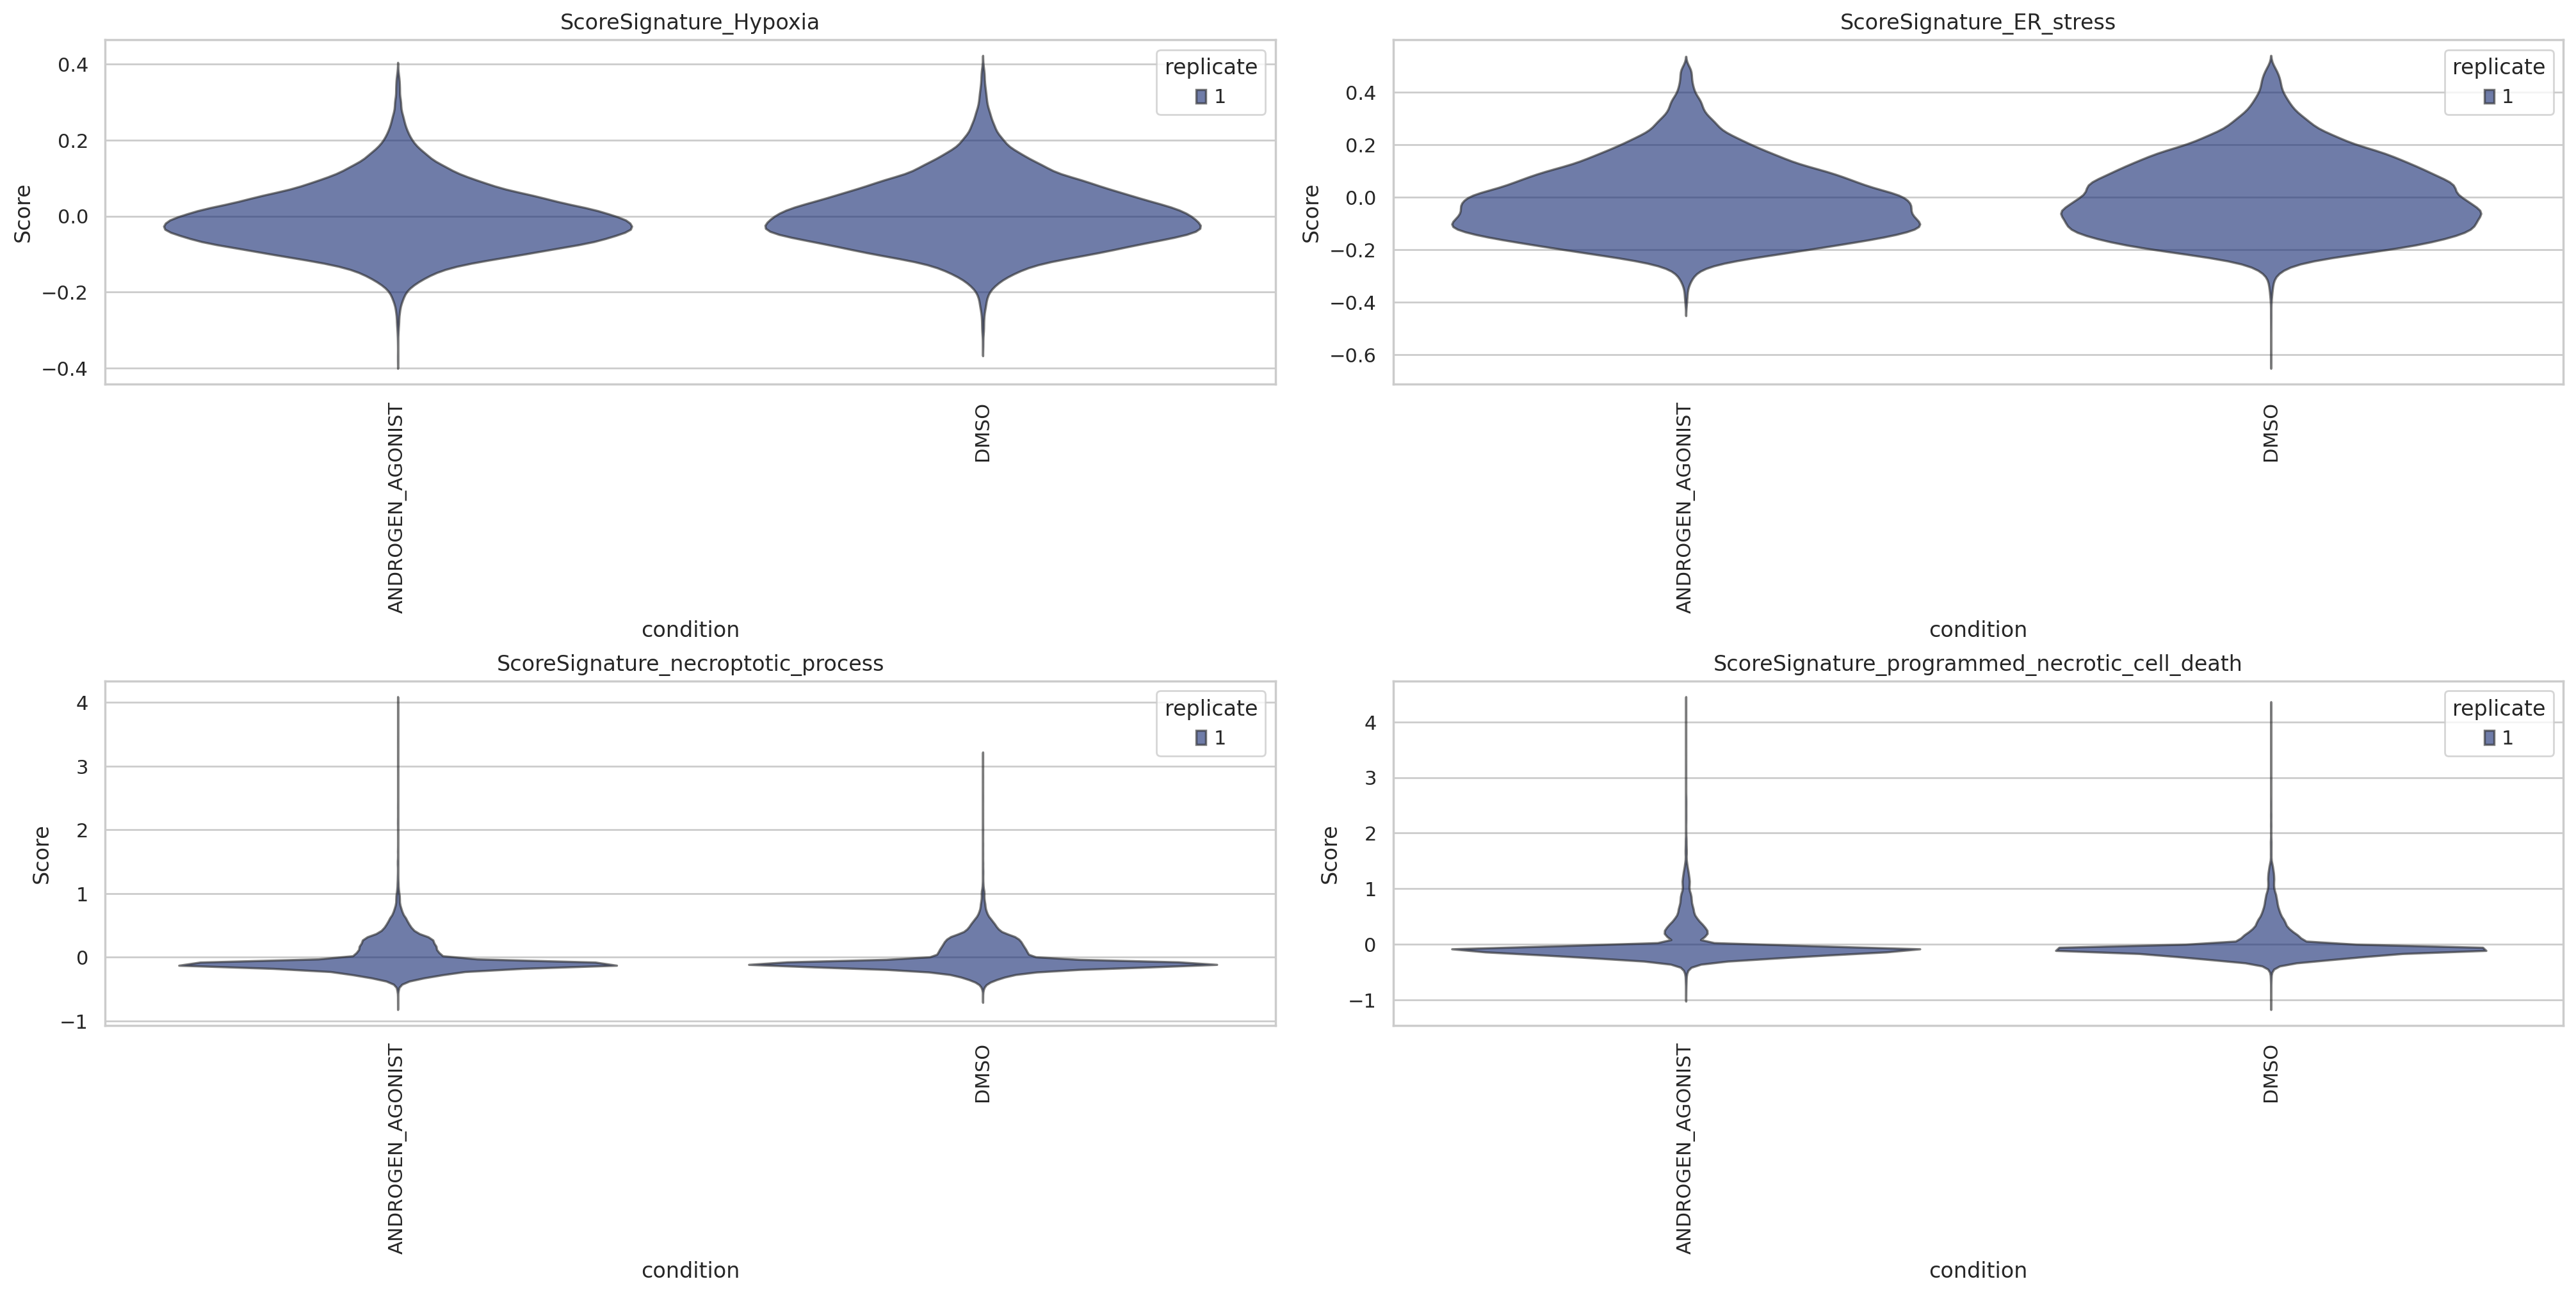

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the theme
sns.set_theme(style="whitegrid")

# Identify the signatures
signatures = [s for s in adata.obs.columns if "ScoreSignature_" in s]

# Set up subplots
n_cols = 2  # Number of columns
n_rows = len(signatures) // n_cols + (len(signatures) % n_cols > 0)  # Number of rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), constrained_layout=True)

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot each signature
for n, signature in enumerate(signatures):
    sns.violinplot(
        data=adata.obs,inner=None,
        x="condition", y=signature, hue="replicate", palette="dark", alpha=.6, ax=axes[n]
    )
    axes[n].set_title(signature)
    axes[n].set_ylabel("Score")  # Set y-axis label
    axes[n].tick_params(axis="x", rotation=90)  # Rotate x-axis tick labels

# Remove unused axes
for i in range(len(signatures), len(axes)):
    fig.delaxes(axes[i])

# Show the plot
plt.show()


In [24]:
adata


AnnData object with n_obs × n_vars = 47245 × 33025
    obs: 'tags', 'cmo', 'condition', 'replicate', 'condition_clean', 'line', 'run', 'sample_id', 'groupCov', 'harmonizedRegion', 'tissue', 'PCW', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'log_pct_counts_hb', 'log_total_counts', 'study', 'hormones_substudy', 'EDCs_substudy', 'androgen_substudy', 'controls_substudy', 'ScoreSignature_Hypoxia', 'ScoreSignature_ER_stress', 'ScoreSignature_necroptotic_process', 'ScoreSignature_programmed_necrotic_cell_death'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropo

In [25]:
## It seems that GO:0097300 (necrosis) got sharp bimodal distribution, let's forecast a filtering result on > 0
(adata.obs["ScoreSignature_programmed_necrotic_cell_death"] < 0).sum()

36521

### There are replicates with spiking values of some markers, it is worthed in this case aggregate by condition and not sample ID

--------------------------------------------------------ScoreSignature_ER_stress--------------------------------------------------------


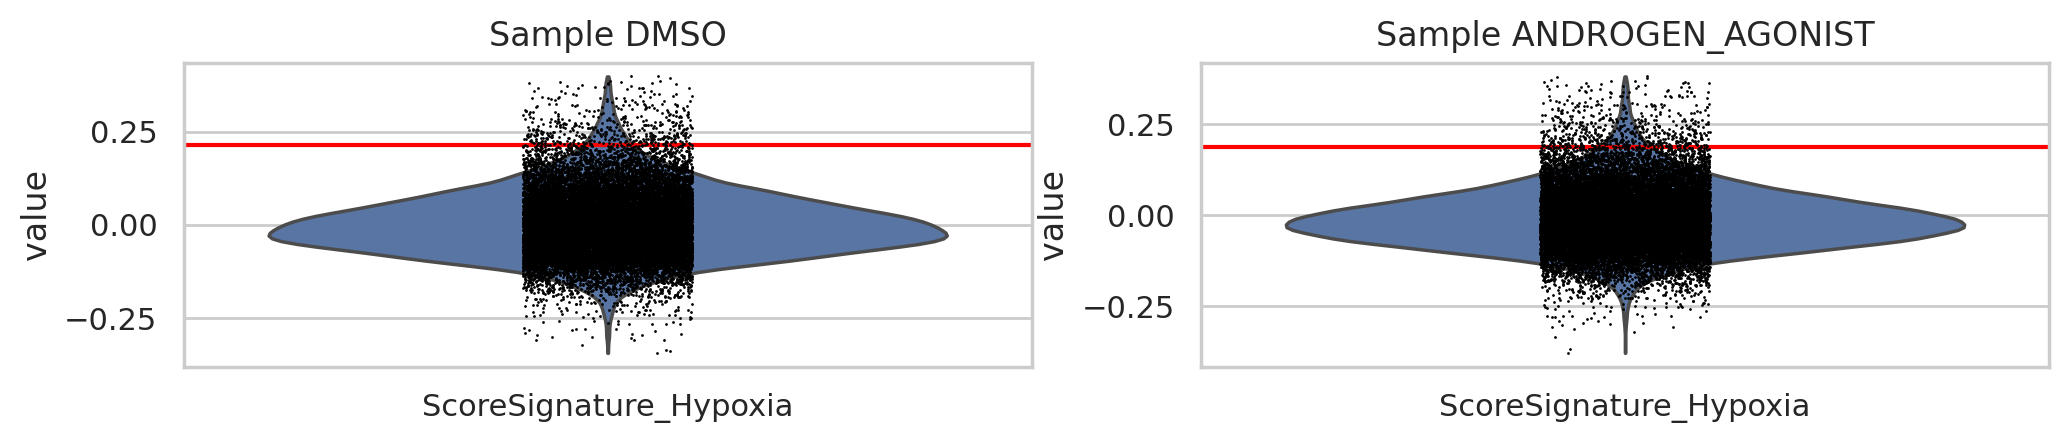

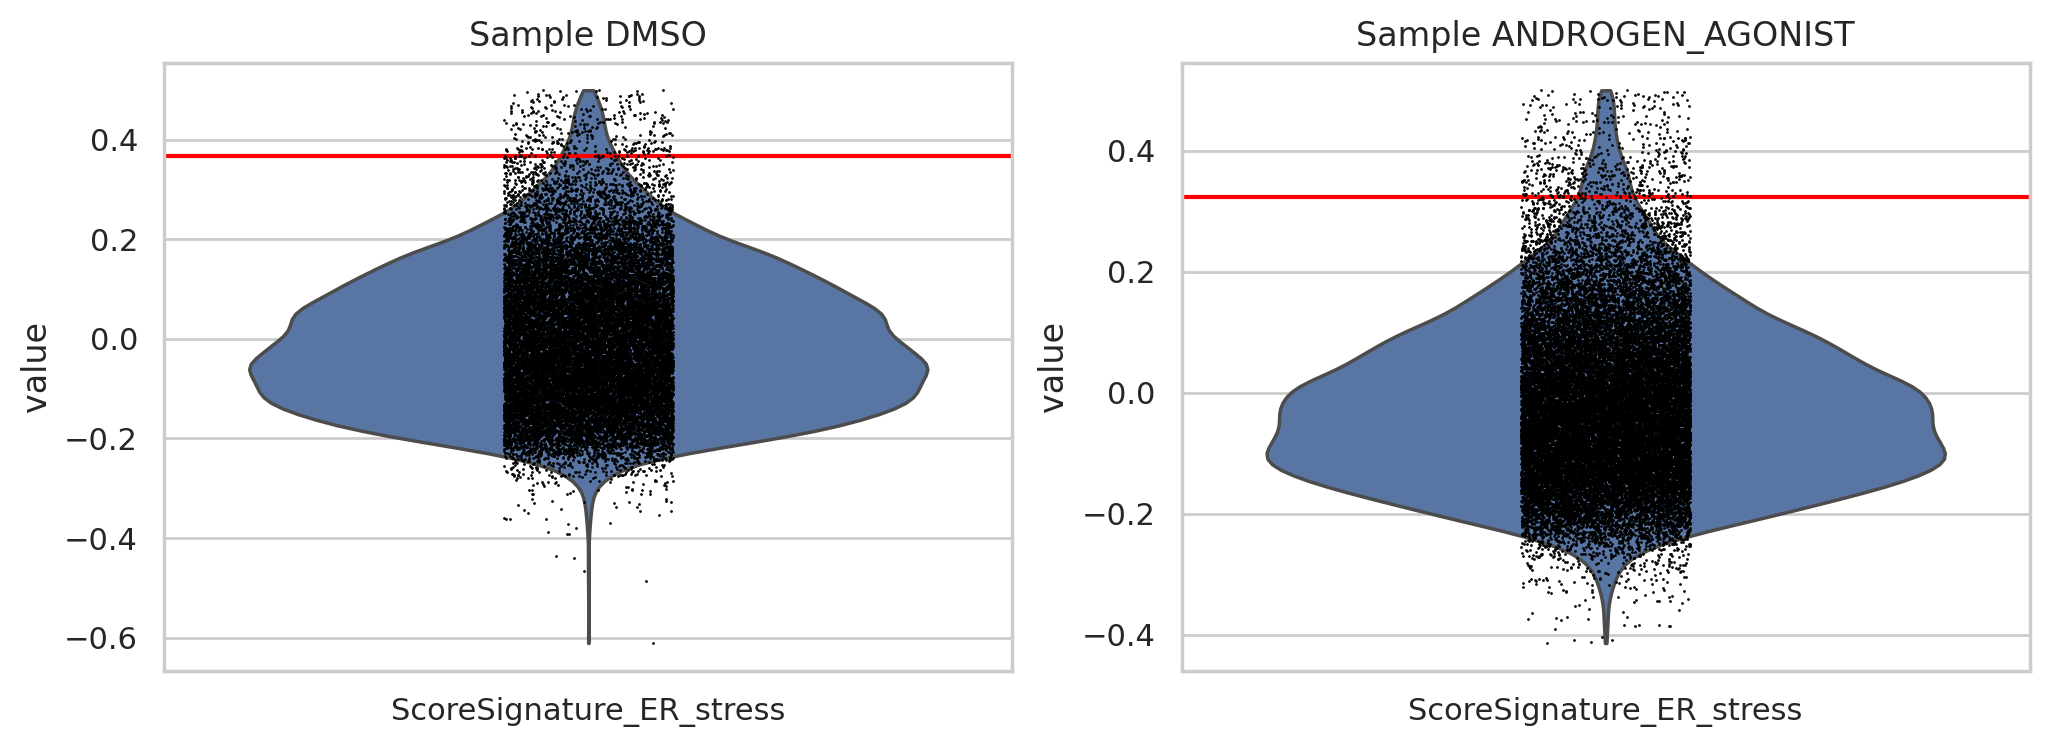




--------------------------------------------------------ScoreSignature_necroptotic_process--------------------------------------------------------


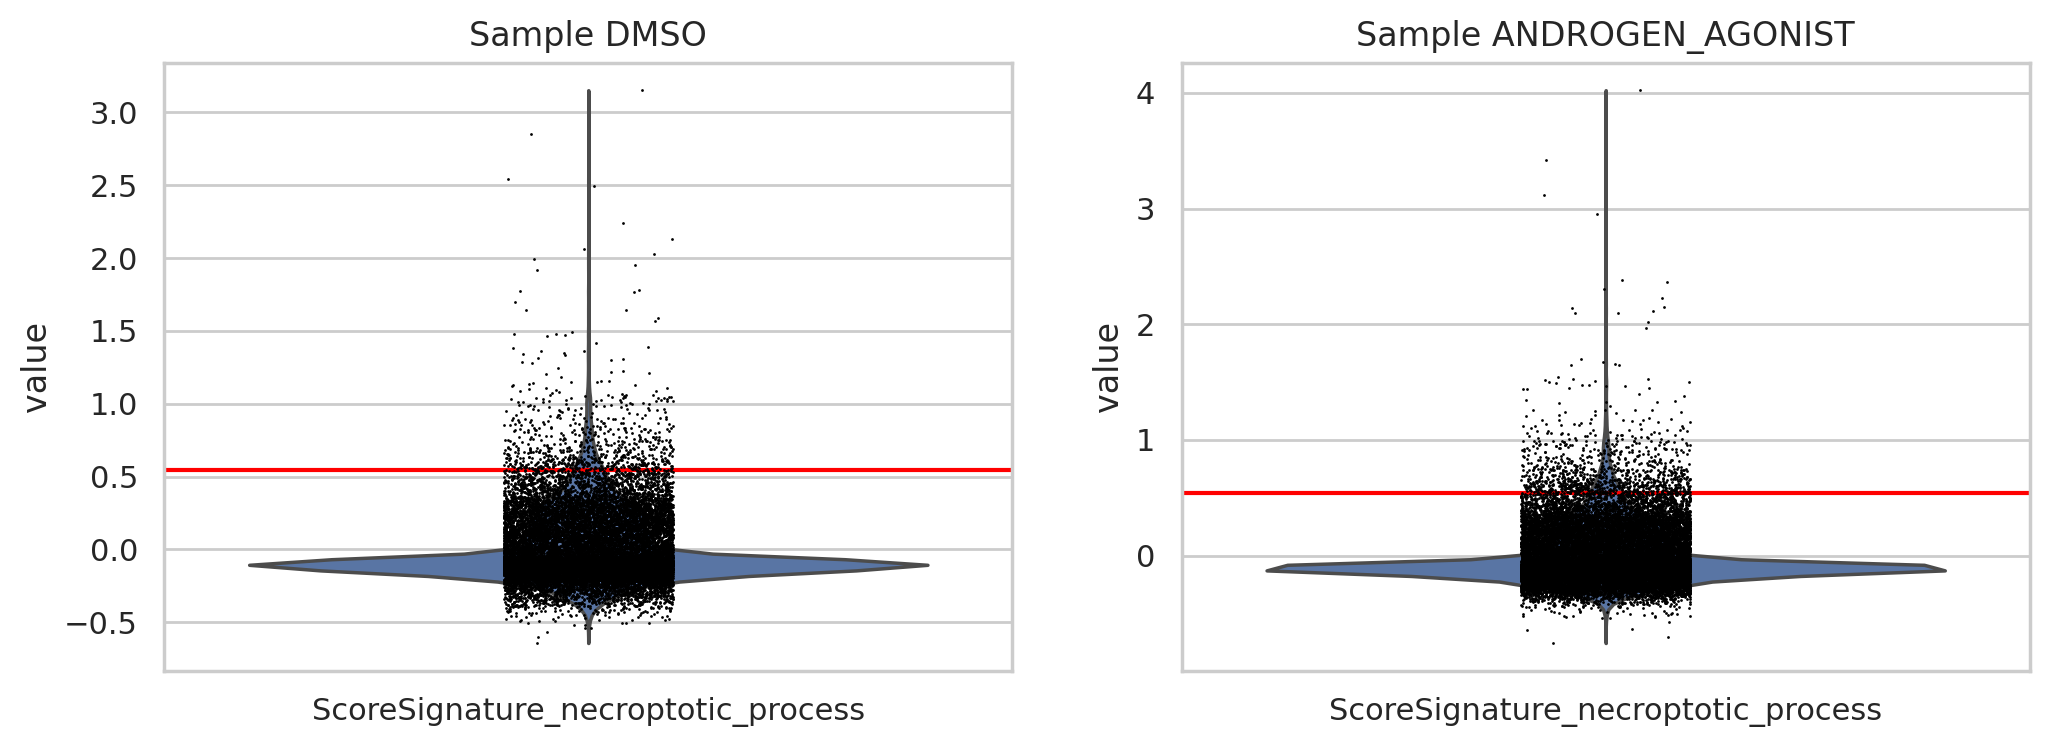




--------------------------------------------------------ScoreSignature_programmed_necrotic_cell_death--------------------------------------------------------


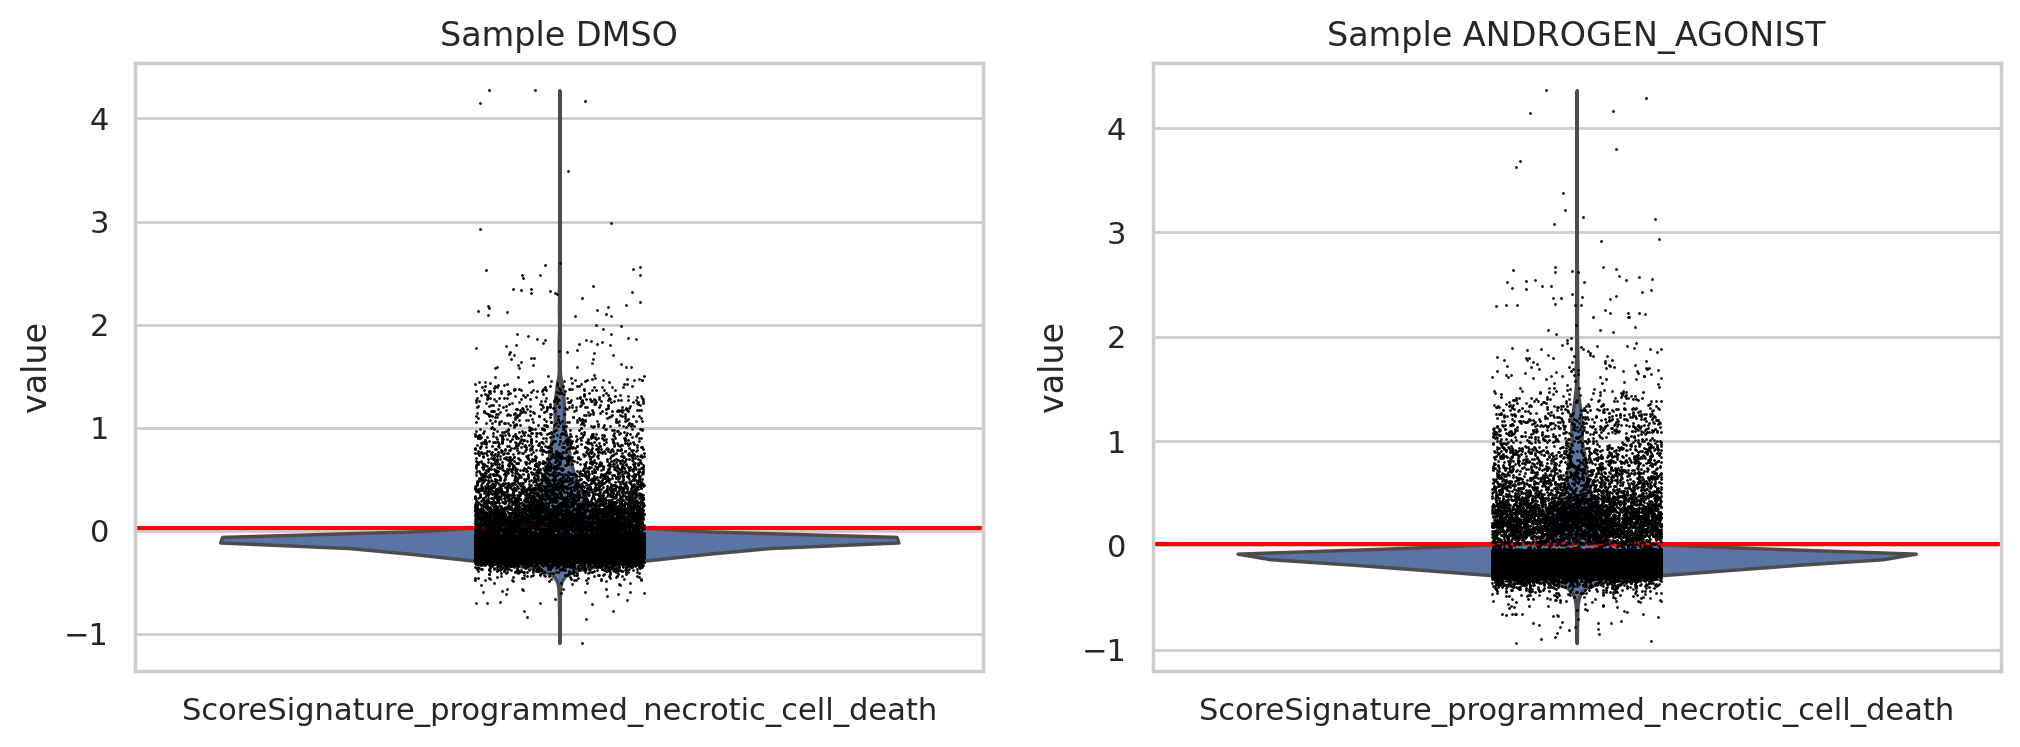

In [26]:
FilterGroup = "condition"
import math
goodBClist = {}

########################################################### RIBO genes
#adata = adata.obs["condition"].isin(["ESTROGEN_ANTAGONIST","RET_AGONIST"])
fig, axes = plt.subplots(math.ceil(len(adata.obs[FilterGroup].unique())/4),4, figsize=(25, 1*len(adata.obs[FilterGroup].unique())), sharey=False)
plt.subplots_adjust(hspace=1)
excess_axes_count = len(axes.flatten()) - len(adata.obs[FilterGroup].unique())



var = "ScoreSignature_Hypoxia"
n = 0
goodBClist[var] = []
for i in adata.obs[FilterGroup].unique():
    AdataTMP = adata[adata.obs[FilterGroup] == i].copy()
    mean =  AdataTMP.obs[var].mean()
    mad = abs((AdataTMP.obs[var] - mean)).sum() / AdataTMP.shape[0]
    max = mean+3*mad
    axes.flatten()[n] = sc.pl.violin(AdataTMP, keys=var, show=False, ax = axes.flatten()[n])
    axes.flatten()[n].axhline(y=max, xmin=0, xmax=1, color="red")
    axes.flatten()[n].title.set_text("Sample {}".format(i))
    goodBClist[var].extend(AdataTMP.obs_names[AdataTMP.obs[var] <= max].tolist())
    n = n+1
goodBClist[var] = set(goodBClist[var])

for i in range(excess_axes_count):
    fig.delaxes(axes.flatten()[-(i+1)])


########################################################### MITO genes
fig, axes = plt.subplots(math.ceil(len(adata.obs[FilterGroup].unique())/4),4, figsize=(25, 2*len(adata.obs[FilterGroup].unique())), sharey=False)
plt.subplots_adjust(hspace=1)
var = "ScoreSignature_ER_stress"
print("--------------------------------------------------------{}--------------------------------------------------------".format(var))

goodBClist[var] = []
n = 0
#goodBClist = []
for i in adata.obs[FilterGroup].unique():
    AdataTMP = adata[adata.obs[FilterGroup] == i].copy()
    mean =  AdataTMP.obs[var].mean()
    mad = abs((AdataTMP.obs[var] - mean)).sum() / AdataTMP.shape[0]
    max = mean+3*mad
    axes.flatten()[n] = sc.pl.violin(AdataTMP, keys=var, show=False, ax = axes.flatten()[n])
    axes.flatten()[n].axhline(y=max, xmin=0, xmax=1, color="red")
    axes.flatten()[n].title.set_text("Sample {}".format(i))
    goodBClist[var].extend(AdataTMP.obs_names[AdataTMP.obs[var] <= max].tolist())
    n = n+1
goodBClist[var] = set(goodBClist[var])




for i in range(excess_axes_count):
    fig.delaxes(axes.flatten()[-(i+1)])

plt.show()

print("\n\n")

########################################################### HBH genes
fig, axes = plt.subplots(math.ceil(len(adata.obs[FilterGroup].unique())/4),4, figsize=(25, 2*len(adata.obs[FilterGroup].unique())), sharey=False)
plt.subplots_adjust(hspace=1)
var = "ScoreSignature_necroptotic_process"
print("--------------------------------------------------------{}--------------------------------------------------------".format(var))
n = 0
goodBClist[var] = []
#goodBClist = []
for i in adata.obs[FilterGroup].unique():
    AdataTMP = adata[adata.obs[FilterGroup] == i].copy()
    mean =  AdataTMP.obs[var].mean()
    mad = abs((AdataTMP.obs[var] - mean)).sum() / AdataTMP.shape[0]
    max = mean+3*mad
    axes.flatten()[n] = sc.pl.violin(AdataTMP, keys=var, show=False, ax = axes.flatten()[n])
    axes.flatten()[n].axhline(y=max, xmin=0, xmax=1, color="red")
    axes.flatten()[n].title.set_text("Sample {}".format(i))
    goodBClist[var].extend(AdataTMP.obs_names[AdataTMP.obs[var] <= max].tolist())
    n = n+1
goodBClist[var] = set(goodBClist[var])


for i in range(excess_axes_count):
    fig.delaxes(axes.flatten()[-(i+1)])

plt.show()

print("\n\n")

########################################################### HBH genes
fig, axes = plt.subplots(math.ceil(len(adata.obs[FilterGroup].unique())/4),4, figsize=(25, 2*len(adata.obs[FilterGroup].unique())), sharey=False)
plt.subplots_adjust(hspace=1)
var = "ScoreSignature_programmed_necrotic_cell_death"
print("--------------------------------------------------------{}--------------------------------------------------------".format(var))

n = 0
goodBClist[var] = []
#goodBClist = []
for i in adata.obs[FilterGroup].unique():
    AdataTMP = adata[adata.obs[FilterGroup] == i].copy()
    mean =  AdataTMP.obs[var].mean()
    mad = abs((AdataTMP.obs[var] - mean)).sum() / AdataTMP.shape[0]
    max = mean+.1*mad
    axes.flatten()[n] = sc.pl.violin(AdataTMP, keys=var, show=False, ax = axes.flatten()[n])
    axes.flatten()[n].axhline(y=max, xmin=0, xmax=1, color="red")
    axes.flatten()[n].title.set_text("Sample {}".format(i))
    goodBClist[var].extend(AdataTMP.obs_names[AdataTMP.obs[var] <= max].tolist())
    n = n+1
goodBClist[var] = set(goodBClist[var])


for i in range(excess_axes_count):
    fig.delaxes(axes.flatten()[-(i+1)])

plt.show()
print("\n\n")

In [27]:

adataPrefilt = adata[list(set.intersection(*list(goodBClist.values())))]
NumberGoodCells = adataPrefilt.shape[0]
GoodCellsRate = adataPrefilt.shape[0]/adata.shape[0]
print("Thresholding like this will results in {} cells kept".format(NumberGoodCells))
print("Which corresponds to {} cells rate".format(round(GoodCellsRate,2)))

Thresholding like this will results in 34621 cells kept
Which corresponds to 0.73 cells rate


In [28]:
for i in list(goodBClist.keys()):
    adata.obs["PassedQCfilt_{}".format(i)] = adata.obs_names.isin(goodBClist[i])

In [29]:
adata.obs[[i for i in adata.obs.columns if "PassedQCfilt_" in i]].to_csv("./adatas/{}_AdditionalFilters.tsv".format(DS), sep="\t")